In [1]:
! pip install Bio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 272 kB 39.6 MB/s 
     |████████████████████████████████| 3.1 MB 68.6 MB/s 


In [2]:
!wget https://ftp.ncbi.nlm.nih.gov/genomes/TOOLS/ORFfinder/linux-i64/ORFfinder.gz
!gzip -kd ORFfinder.gz

--2022-12-25 22:41:41--  https://ftp.ncbi.nlm.nih.gov/genomes/TOOLS/ORFfinder/linux-i64/ORFfinder.gz
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 165.112.9.230, 130.14.250.7, 2607:f220:41e:250::12, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|165.112.9.230|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8386303 (8.0M) [application/x-gzip]
Saving to: ‘ORFfinder.gz’

ORFfinder.gz        100%[===================>]   8.00M  --.-KB/s    in 0.09s   

2022-12-25 22:41:41 (90.0 MB/s) - ‘ORFfinder.gz’ saved [8386303/8386303]



In [3]:
!apt-get install libdw1
!chmod u+x ./ORFfinder

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  libdw1
0 upgraded, 1 newly installed, 0 to remove and 20 not upgraded.
Need to get 203 kB of archives.
After this operation, 795 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libdw1 amd64 0.170-0.4ubuntu0.1 [203 kB]
Fetched 203 kB in 0s (2,382 kB/s)
Selecting previously unselected package libdw1:amd64.
(Reading database ... 124016 files and directories currently installed.)
Preparing to unpack .../libdw1_0.170-0.4ubuntu0.1_amd64.deb ...
Unpacking libdw1:amd64 (0.170-0.4ubuntu0.1) ...
Setting up libdw1:amd64 (0.170-0.4ubuntu0.1) ...
Processing triggers for libc-bin (2.27-3ubuntu1.6) ...


In [5]:
!./ORFfinder -in fragment18.fasta -out ORFs_f18.fasta -g 11 -outfmt 0

Создадим словарь с ORFs, чтобы к ним было удобнее обращаться в будущем.

In [197]:
orfs_dict = {}
with open('ORFs_f18.fasta','r') as f1:
  f1 = f1.read()
  f1 = f1.split('>')
  for el in f1:
    if el != '':
      el1 = el.split('\n')
      orf = el1[0].split('|')[1]
      orf = orf.split(':')[0].split('_')[0]
      aminoacids = el1[1]
      orfs_dict[orf] = aminoacids

Дальше отправляем данный файл в Blast в базу Uniprot.

In [95]:
import pandas as pd

In [96]:
uniprot = pd.read_csv('uniprot.csv',header=None)

In [97]:
uniprot

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,lcl|ORF13_1:3900:4673,Q63A38.1,40.351,228,134,1,21,248,19,244,6.020000e-67,209.0,68.42
1,lcl|ORF13_1:3900:4673,Q736E0.1,40.351,228,134,1,21,248,19,244,1.500000e-66,209.0,67.98
2,lcl|ORF13_1:3900:4673,A0RFA4.2,39.912,228,135,1,21,248,19,244,1.670000e-66,208.0,68.42
3,lcl|ORF13_1:3900:4673,Q81C68.1,39.474,228,136,1,21,248,19,244,5.520000e-66,207.0,66.67
4,lcl|ORF13_1:3900:4673,Q6HHI7.1,39.819,221,131,1,21,241,19,237,4.950000e-64,202.0,68.78
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4844,lcl|ORF1336_1:8147:7872,Q8FT41.1,36.471,85,47,2,1,79,302,385,1.820000e-07,49.3,51.76
4845,lcl|ORF1336_1:8147:7872,Q04R57.1,33.333,78,50,1,2,79,277,352,2.580000e-07,48.5,52.56
4846,lcl|ORF1336_1:8147:7872,B8IZS6.1,33.721,86,55,1,2,87,291,374,2.910000e-07,48.5,47.67
4847,lcl|ORF1336_1:8147:7872,Q8F6R2.2,30.952,84,56,1,2,85,277,358,6.030000e-07,47.8,52.38


In [98]:
uniprot = uniprot.rename(columns={0: "orf", 1: "gene", 2: "value",3:'length', 4:'mismatches',5:'gap-opens', 10:'e_value', 11:'score'})

In [99]:
uniprot_right = uniprot[uniprot.value > 85]

In [100]:
uniprot_right = uniprot_right[uniprot_right.e_value <= 0.05]

Отсортируем файл по повторяющимся рамкам считывания.

In [101]:
columns_ = uniprot_right.orf.value_counts()[uniprot_right.orf.value_counts()>1]

In [102]:
same_uniprot = uniprot_right[uniprot_right['orf'].isin(columns_.axes[0])]

In [103]:
same2 = same_uniprot['orf'].unique()

In [104]:
same_uniprot[same_uniprot.orf == same2[0]]

,orf,gene,value,length,mismatches,gap-opens,6,7,8,9,e_value,score,12
1162,lcl|ORF241_1:11116:11571,O08319.2,87.069,116,15,0,3,118,287,402,3.250000e-63,200.0,88.79
1259,lcl|ORF241_1:11116:11571,O08320.2,88.889,27,3,0,125,151,1,27,4.730000e-07,49.7,92.59


In [105]:
for el in same2:
  values = same_uniprot[same_uniprot.orf == same2[0]]
  max_value = values.value.max()
  main_index = values[values.value == max_value].index
  delete_indexes = [i for i in list(values.index) if i not in list(main_index)]
  uniprot_right = uniprot_right.drop(delete_indexes)

In [106]:
uniprot_right

,orf,gene,value,length,mismatches,gap-opens,6,7,8,9,e_value,score,12
200,lcl|ORF34_1:12621:12899,O08321.4,89.011,91,10,0,1,91,131,221,7.220000e-51,166.0,92.31
832,lcl|ORF237_1:9574:9861,O08318.2,87.368,95,12,0,1,95,123,217,7.190000e-54,172.0,93.68
1062,lcl|ORF240_1:10588:11100,O08319.2,85.882,170,24,0,1,170,109,278,1.020000e-98,292.0,92.35
1259,lcl|ORF241_1:11116:11571,O08320.2,88.889,27,3,0,125,151,1,27,4.730000e-07,49.7,92.59
1262,lcl|ORF242_1:11668:12009,O08320.2,86.607,112,15,0,2,113,62,173,2.900000e-60,186.0,89.29
1288,lcl|ORF243_1:12103:12306,O08320.2,86.047,43,6,0,1,43,206,248,3.880000e-16,71.2,93.02
1363,lcl|ORF250_1:13684:13773,O08322.2,85.185,27,4,0,3,29,100,126,5.130000e-10,53.1,96.30
1563,lcl|ORF252_1:13981:14253,O08322.2,91.026,78,7,0,13,90,209,286,7.010000e-44,146.0,93.59
1663,lcl|ORF253_1:14338:14415,O08322.2,91.667,24,2,0,2,25,317,340,3.160000e-08,47.8,91.67
1989,lcl|ORF302_1:31822:34101,C6VKW6.1,100.000,745,0,0,15,759,1,745,0.000000e+00,1528.0,100.00


Теперь мы должны разбить на координаты оригинальный датафрейм Юнипрот и датафрейм с отсортированным Юнипротом для того, чтобы найти пересекающиеся и повторяющиеся рамки считывания.

In [107]:
uniprot_right['orf_name'] = uniprot_right['orf'].apply(lambda x: x.split(':')[0])
uniprot_right['coor1'] = uniprot_right['orf'].apply(lambda x: x.split(':')[1])
uniprot_right['coor2'] = uniprot_right['orf'].apply(lambda x: x.split(':')[2])

In [108]:
delete_orfs = set(list(uniprot_right.orf_name))

In [109]:
first_sorting = []
with open('ORFs_f18.fasta','r') as f:
  f = f.read()
  f = f.split('>')
  for el in f:
    if el != '':
      el_ = el.split(':')[0]
      if el_ not in delete_orfs:
        first_sorting.append(el)


Теперь отсортируем пересекающиеся последовательности.

In [110]:
sequences = []
for i in uniprot_right.values:
  r1 = int(i[-2])
  r2 = int(i[-1])
  sequences.append(list(range(r1, r2+1)))


In [111]:
final_sorting = []
for j in first_sorting:
  j_ = j.split()[0].split(':')
  for el in sequences:
    r1 = int(j_[1])
    r2 = int(j_[2])
    if r1 < r2:
      seq2 = list(range(r1, r2+1))
    else:
      seq2 = list(range(r1+1, r2))

    main_seq = list(set(el) & set(seq2))
    if main_seq == []:
      if j not in final_sorting:
        final_sorting.append(j)

In [112]:
with open('ORFs_f18_2.fasta','w') as file_2:
  for k in final_sorting:
    file_2.write('>'+k)

Файл с рамками считывания мы сортируем по рамкам считывания из этого датафрейма и загружаем в другую базу - рефсек.

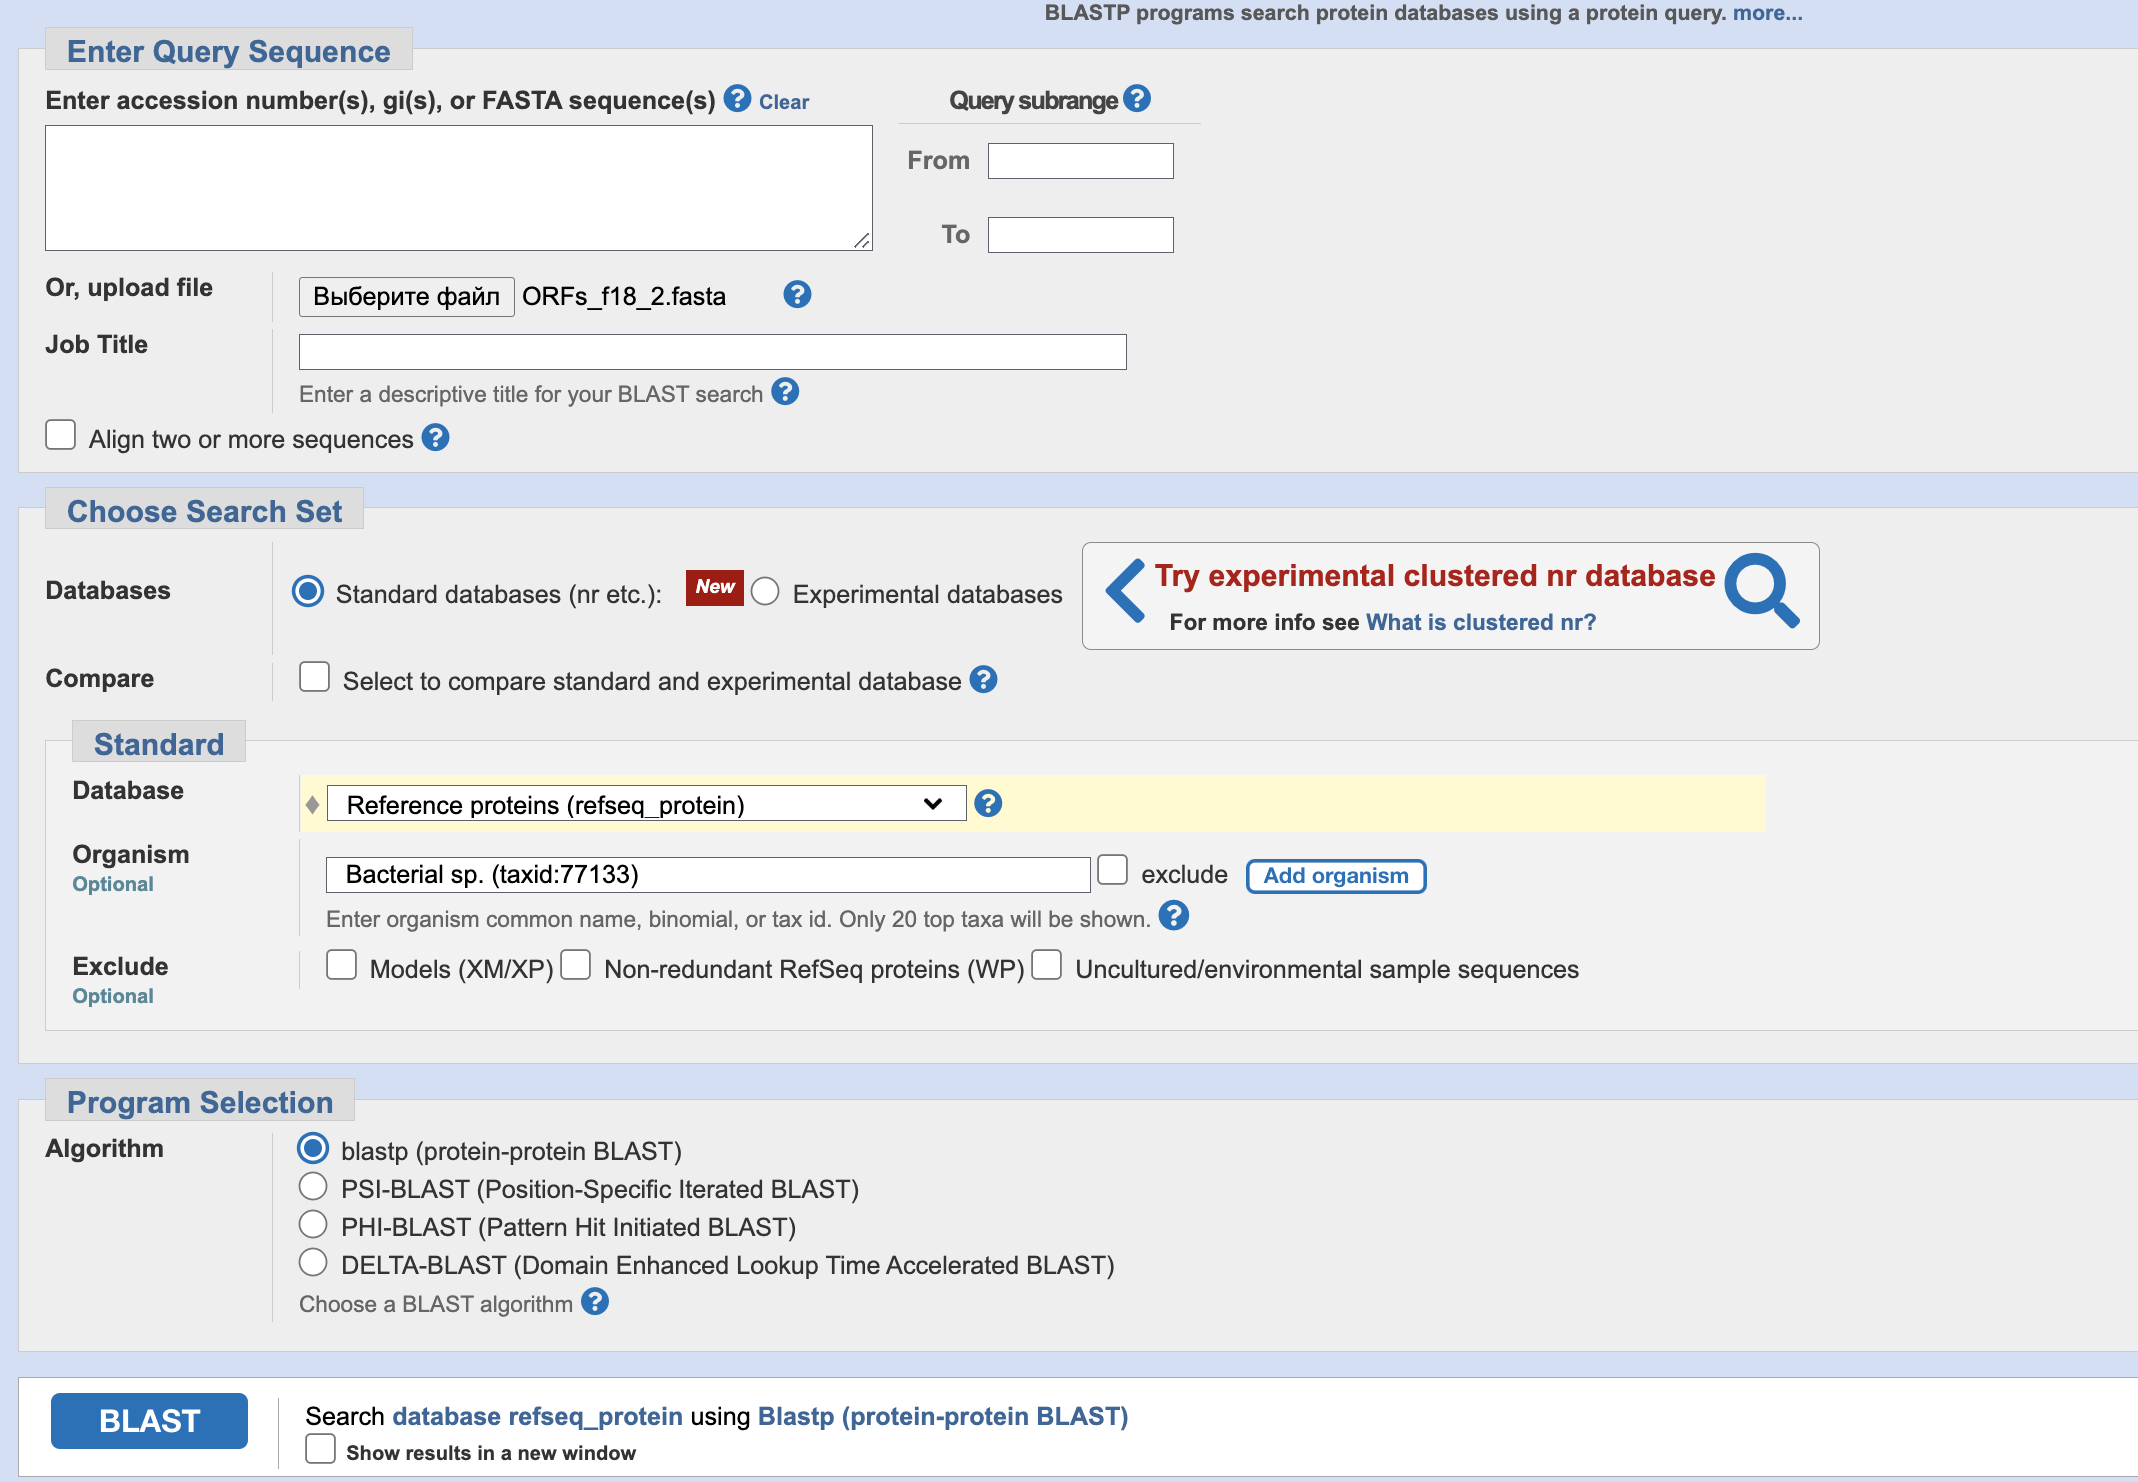

В базе РефСек ничего не нашлось. Я разбила файл с остальными рамками считывания на подфайлы, чтобы они посчитались, но csv-files были пустыми. Текстовые файлы были следующего содеражния:

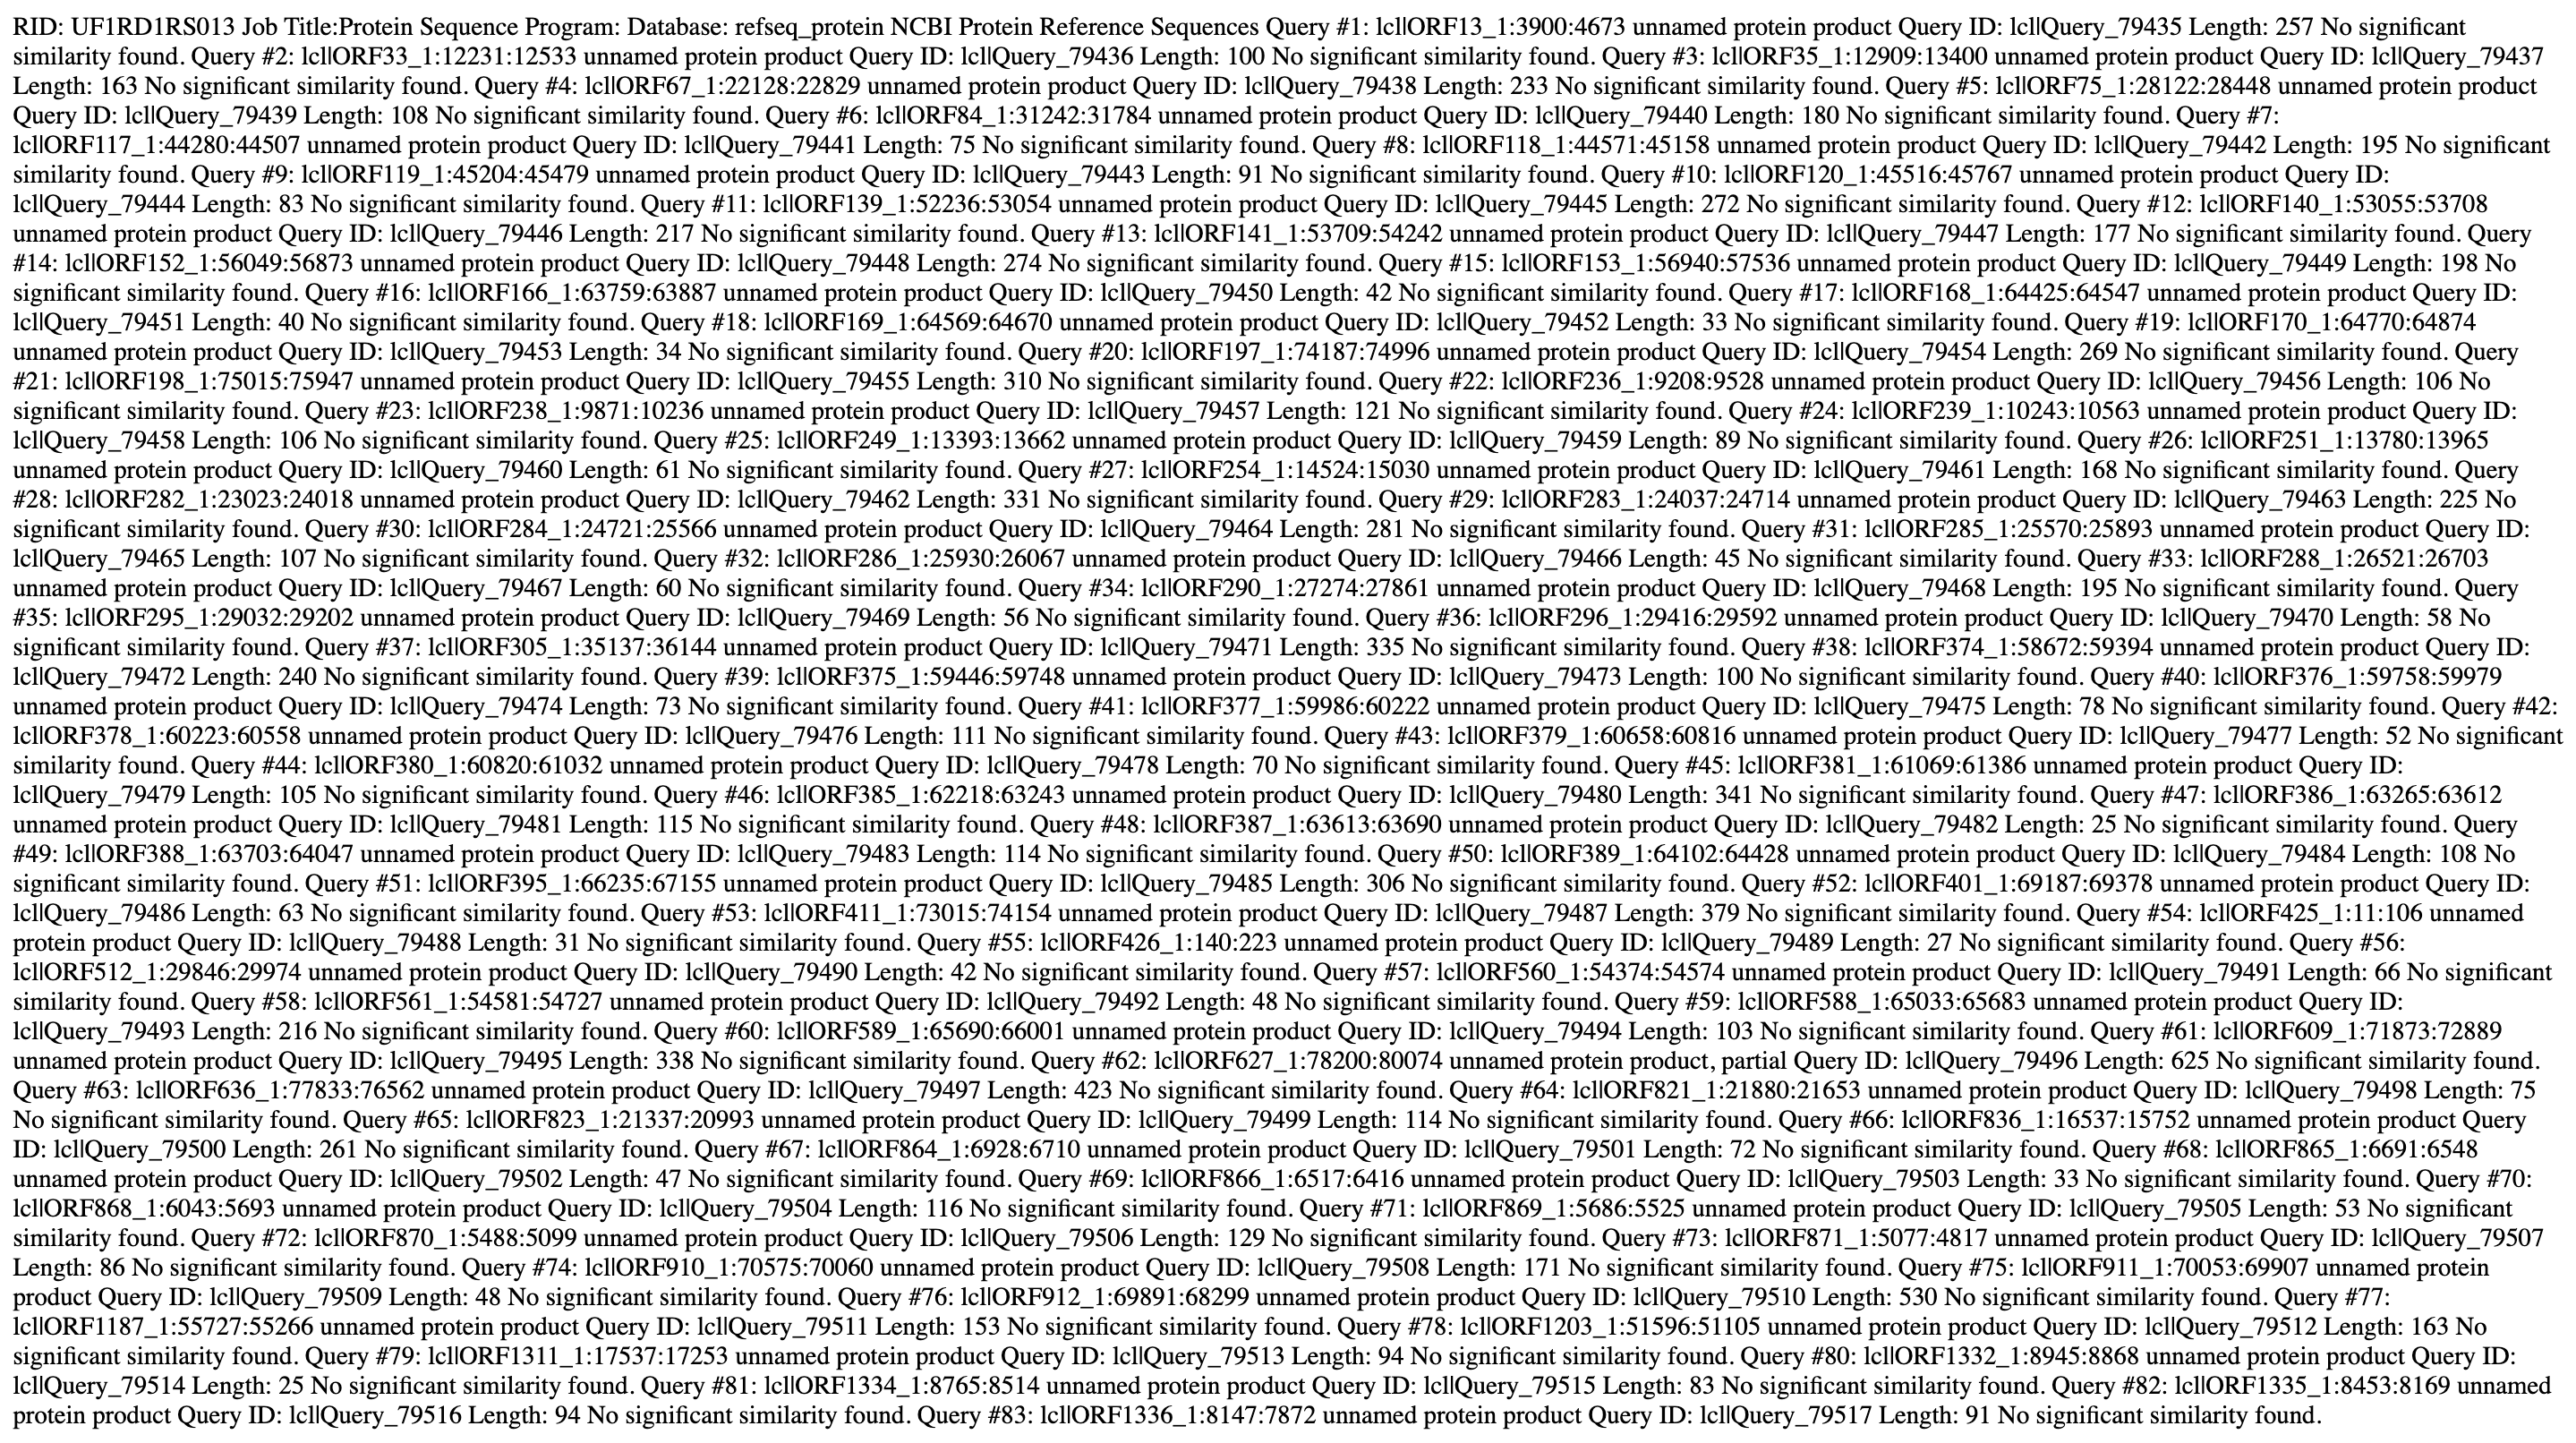

После безуспешной попытки в рефсек, я решила искать в базе non-reduntant. Разбитые ранее файлы я загрузила и посчитала. Там уже файлы оказались непустыми.

In [113]:
all_files = ['orf1.csv','orf2.csv','orf3.csv','orf4.csv','orf5.csv',
             'orf6.csv','orf7.csv','orf8.csv','orf9.csv','orf10.csv']

In [114]:
dfs = list()
for i, f in enumerate(all_files):
    data = pd.read_csv(f, header=None)
    dfs.append(data)

In [115]:
non_red = pd.concat(dfs, ignore_index=True)

In [116]:
non_red = non_red.rename(columns={0: "orf", 1: "gene", 2: "value",3:'length', 4:'mismatches',5:'gap-opens', 10:'e_value', 11:'score'})

In [117]:
non_red = non_red[non_red.value > 85]

In [118]:
non_red = non_red[non_red.e_value <= 0.05]

In [119]:
non_red.head()

,orf,gene,value,length,mismatches,gap-opens,6,7,8,9,e_value,score,12
3,lcl|ORF7_1:2871:2957,POD84562.1,85.714,28,4,0,1,28,1,28,1.320000e-07,51.2,85.71
4,lcl|ORF7_1:2871:2957,WP_256633644.1,85.714,28,4,0,1,28,1,28,1.390000e-07,51.6,85.71
5,lcl|ORF7_1:2871:2957,WP_243683466.1,85.714,28,4,0,1,28,1,28,1.550000e-07,51.6,85.71
6,lcl|ORF7_1:2871:2957,WP_253954629.1,85.714,28,4,0,1,28,1,28,1.650000e-07,51.2,85.71
7,lcl|ORF7_1:2871:2957,WP_237761674.1,85.714,28,4,0,1,28,1,28,2.620000e-07,51.6,85.71


Как с юнипрот, мы должны удалить те участки, которых несколько.

In [120]:
columns_ = non_red.orf.value_counts()[non_red.orf.value_counts()>1]

In [121]:
same_uniprot = non_red[non_red['orf'].isin(columns_.axes[0])]

In [122]:
same2 = same_uniprot['orf'].unique()

In [123]:
import random 
import numpy as np

In [124]:
non_red_right = non_red.copy()

In [125]:
for el in same2:
  values = non_red[non_red.orf == el]
  max_value = values.value.max()
  
  main_index = values[values.value == max_value].index
  if len(main_index.values) > 1:
    max_value = values.e_value.min()

  main_index = values[values.value == max_value].index
  delete_indexes = [i for i in list(values.index) if i not in list(main_index)]
  non_red_right = non_red_right.drop(delete_indexes)

In [126]:
non_red_right.head()

,orf,gene,value,length,mismatches,gap-opens,6,7,8,9,e_value,score,12
89,lcl|ORF8_1:2967:3050,WP_151502022.1,92.000,25,2,0,3,27,35,59,1.770000e-05,49.3,100.00
850,lcl|ORF36_1:13791:13880,KLD58957.1,85.185,27,4,0,1,27,1,27,2.180000e-05,48.5,88.89
939,lcl|ORF67_1:22128:22829,WP_131067693.1,85.586,111,16,0,39,149,1,111,1.010000e-60,196.0,89.19
1098,lcl|ORF76_1:28530:28928,WP_243671785.1,86.747,83,11,0,1,83,1,83,2.290000e-32,119.0,89.16
1158,lcl|ORF84_1:31242:31784,WP_003642086.1,100.000,180,0,0,1,180,1,180,5.520000e-126,361.0,100.00


Объединим находки из базы Uniprot и Non-Reduntant.

In [127]:
non_red_right['orf_name'] = non_red_right['orf'].apply(lambda x: x.split(':')[0])
non_red_right['coor1'] = non_red_right['orf'].apply(lambda x: x.split(':')[1])
non_red_right['coor2'] = non_red_right['orf'].apply(lambda x: x.split(':')[2])

In [128]:
final_df = pd.concat([uniprot_right, non_red_right], ignore_index=True)

С помощю tRNA получили последовательности:

In [217]:
rnas = {'rna1':{'aminoacid':'Ile',
                'anticodon':'GAT',
                'coors':[40001,40075]},
        'rna2':{'aminoacid':'Ala',
                'anticodon':'TGC',
                'coors':[40117,40189]},
        'rna3':{'aminoacid':'Tyr',
                'anticodon':'GTA',
                'coors':[43464,43536]},
        'rna4':{'aminoacid':'Thr',
                'anticodon':'CGT',
                'coors':[43582,43654]},
        'rna5':{'aminoacid':'Tyr',
                'anticodon':'GTA',
                'coors':[46741,46823]},
        'rna6':{'aminoacid':'Leu',
                'anticodon':'AAG',
                'coors':[67167,67251]}}

Сравним с ARAGORN.

In [218]:
rnas_aragorn = {'rna1':{'aminoacid':'Ile',
                        'anticodon':'GAT',
                        'coors':[40000,40076]},
                'rna2':{'aminoacid':'Ala',
                        'anticodon':'TGC',
                        'coors':[40116,40190]},
                'rna3':{'aminoacid':'Tyr',
                        'anticodon':'GTA',
                        'coors':[43463,43537]},
                'rna4':{'aminoacid':'Thr',
                        'anticodon':'CGT',
                        'coors':[43582,43654]},
                'rna5':{'aminoacid':'Tyr',
                        'anticodon':'GTA',
                        'coors':[46741,46823]},
                'rna6':{'aminoacid':'Leu',
                        'anticodon':'AAG',
                        'coors':[67166,67252]}}

Теперь излвечем межгенные участки:

In [131]:
final_df

,orf,gene,value,length,mismatches,gap-opens,6,7,8,9,e_value,score,12,orf_name,coor1,coor2
0,lcl|ORF34_1:12621:12899,O08321.4,89.011,91,10,0,1,91,131,221,7.220000e-51,166.0,92.31,lcl|ORF34_1,12621,12899
1,lcl|ORF237_1:9574:9861,O08318.2,87.368,95,12,0,1,95,123,217,7.190000e-54,172.0,93.68,lcl|ORF237_1,9574,9861
2,lcl|ORF240_1:10588:11100,O08319.2,85.882,170,24,0,1,170,109,278,1.020000e-98,292.0,92.35,lcl|ORF240_1,10588,11100
3,lcl|ORF241_1:11116:11571,O08320.2,88.889,27,3,0,125,151,1,27,4.730000e-07,49.7,92.59,lcl|ORF241_1,11116,11571
4,lcl|ORF242_1:11668:12009,O08320.2,86.607,112,15,0,2,113,62,173,2.900000e-60,186.0,89.29,lcl|ORF242_1,11668,12009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,lcl|ORF1239_1:40481:40386,MQM78576.1,95.833,24,1,0,7,30,1,24,5.650000e-06,47.0,95.83,lcl|ORF1239_1,40481,40386
90,lcl|ORF1240_1:39803:39714,KAF0173558.1,100.000,26,0,0,4,29,1,26,2.650000e-09,55.5,100.00,lcl|ORF1240_1,39803,39714
91,lcl|ORF1242_1:39482:39327,KMV78111.1,95.000,20,1,0,4,23,1,20,4.180000e-04,44.3,100.00,lcl|ORF1242_1,39482,39327
92,lcl|ORF1243_1:39272:38931,CCB82280.1,99.048,105,1,0,9,113,1,105,6.820000e-68,209.0,99.05,lcl|ORF1243_1,39272,38931


In [132]:
with open('ann_orfs.bed','w') as f_out:
  for i in final_df.values:
    if int(i[14]) < int(i[15]):
      strand = '+'
    else:
      strand = '-'
    start = min(int(i[14]), int(i[15]))
    end = max(int(i[14]), int(i[15]))

    if i[0] != None:
      k = i[0].split('|')[1]
      k = k.split(':')[0].split('_')[0]
    else:
      k = i[1]

    f_out.write('fragment18\t{}\t{}\t{}\t*\t{}\n'.format(start, end,k,strand))


In [133]:
! apt-get install samtools

Reading package lists... Done
Building dependency tree       
Reading state information... Done
samtools is already the newest version (1.7-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.


In [134]:
! apt-get install bedtools

Reading package lists... Done
Building dependency tree       
Reading state information... Done
bedtools is already the newest version (2.26.0+dfsg-5).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.


In [135]:
! samtools faidx fragment18.fasta

In [136]:
! cut -f 1,2 fragment18.fasta.fai > chrom.sizes

In [137]:
! bedtools sort -i ann_orfs.bed > sorted_ann_orfs.bed
! bedtools complement -i sorted_ann_orfs.bed -g chrom.sizes > inters.bed
! bedtools getfasta -fi fragment18.fasta -bed inters.bed > inters.fasta

База refseq_select ничего не дала, однако база refseq_rna дала.


In [138]:
ann_blastn = pd.read_csv('ann_blastn.csv', header=None)

In [139]:
ann_blastn = ann_blastn.rename(columns={0: "orf", 1: "gene", 2: "value",3:'length', 4:'mismatches',5:'gap-opens', 10:'e_value', 11:'score'})

In [140]:
ann_blastn = ann_blastn[ann_blastn.value > 85]

In [141]:
ann_blastn = ann_blastn[ann_blastn.e_value <= 0.05]

In [142]:
columns_ = ann_blastn.orf.value_counts()[ann_blastn.orf.value_counts()>1]

In [143]:
same_ann_blastn = ann_blastn[ann_blastn['orf'].isin(columns_.axes[0])]

In [144]:
same2 = same_ann_blastn['orf'].unique()

In [145]:
same_ann_blastn_right = same_ann_blastn.copy()

In [146]:
for el in same2:
  values = same_ann_blastn[same_ann_blastn.orf == el]
  max_value = values.value.max()
  
  main_index = values[values.value == max_value].index
  if len(main_index.values) > 1:
    max_value = values.e_value.min()

  main_index = values[values.value == max_value].index
  delete_indexes = [i for i in list(values.index) if i not in list(main_index)]
  same_ann_blastn_right = same_ann_blastn_right.drop(delete_indexes)

In [147]:
same_ann_blastn_right

,orf,gene,value,length,mismatches,gap-opens,6,7,8,9,e_value,score
200,fragment18:40921-42100,NR_076229.1,96.265,1071,40,0,90,1160,1,1071,0.000000e+00,1757.0
300,fragment18:42339-42632,NR_076229.1,94.406,286,16,0,3,288,1309,1594,7.190000e-120,440.0
306,fragment18:43122-43464,NR_076229.1,91.716,338,28,0,1,338,2077,2414,1.100000e-128,470.0
528,fragment18:43654-45204,NR_075186.1,94.118,119,7,0,390,508,1,119,2.810000e-41,182.0


In [148]:
same_ann_blastn_right['orf_name'] = same_ann_blastn_right['orf'].apply(lambda x: x.split(':')[0])
same_ann_blastn_right['coor1'] = same_ann_blastn_right['orf'].apply(lambda x: x.split(':')[1].split('-')[0])
same_ann_blastn_right['coor2'] = same_ann_blastn_right['orf'].apply(lambda x: x.split(':')[1].split('-')[1])

In [149]:
final_df2 = pd.concat([final_df, same_ann_blastn_right], ignore_index=True)

In [150]:
final_df2

,orf,gene,value,length,mismatches,gap-opens,6,7,8,9,e_value,score,12,orf_name,coor1,coor2
0,lcl|ORF34_1:12621:12899,O08321.4,89.011,91,10,0,1,91,131,221,7.220000e-51,166.0,92.31,lcl|ORF34_1,12621,12899
1,lcl|ORF237_1:9574:9861,O08318.2,87.368,95,12,0,1,95,123,217,7.190000e-54,172.0,93.68,lcl|ORF237_1,9574,9861
2,lcl|ORF240_1:10588:11100,O08319.2,85.882,170,24,0,1,170,109,278,1.020000e-98,292.0,92.35,lcl|ORF240_1,10588,11100
3,lcl|ORF241_1:11116:11571,O08320.2,88.889,27,3,0,125,151,1,27,4.730000e-07,49.7,92.59,lcl|ORF241_1,11116,11571
4,lcl|ORF242_1:11668:12009,O08320.2,86.607,112,15,0,2,113,62,173,2.900000e-60,186.0,89.29,lcl|ORF242_1,11668,12009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,lcl|ORF1244_1:38858:38712,CUR40292.1,90.625,32,3,0,17,48,40,71,5.860000e-12,63.9,90.62,lcl|ORF1244_1,38858,38712
94,fragment18:40921-42100,NR_076229.1,96.265,1071,40,0,90,1160,1,1071,0.000000e+00,1757.0,NaN,fragment18,40921,42100
95,fragment18:42339-42632,NR_076229.1,94.406,286,16,0,3,288,1309,1594,7.190000e-120,440.0,NaN,fragment18,42339,42632
96,fragment18:43122-43464,NR_076229.1,91.716,338,28,0,1,338,2077,2414,1.100000e-128,470.0,NaN,fragment18,43122,43464


Снова  очищаем последовательности и получаем неаннтированные участки, которые мы потом прогоняем через TBLASTX.

In [151]:
delete_orfs = set(list(final_df2.orf_name))

In [152]:
first_sorting = []
with open('ORFs_f18_2.fasta','r') as f:
  f = f.read()
  f = f.split('>')
  for el in f:
    if el != '':
      el_ = el.split(':')[0]
      if el_ not in delete_orfs:
        first_sorting.append(el)

In [153]:
sequences = []
for i in final_df2.values:
  r1 = int(i[-2])
  r2 = int(i[-1])
  sequences.append(list(range(r1, r2+1)))


In [154]:
final_sorting = []
for j in first_sorting:
  j_ = j.split()[0].split(':')
  for el in sequences:
    r1 = int(j_[1])
    r2 = int(j_[2])
    if r1 < r2:
      seq2 = list(range(r1, r2+1))
    else:
      seq2 = list(range(r1+1, r2))

    main_seq = list(set(el) & set(seq2))
    if main_seq == []:
      if j not in final_sorting:
        final_sorting.append(j)

In [155]:
with open('notann_orfs.bed','w') as f_out:
  for i in final_sorting:
    i = i.split()[0]
    if int(i.split(':')[1]) < int(i.split(':')[2]):
      strand = '+'
    else:
      strand = '-'
    start = min(int(i.split(':')[1]), int(i.split(':')[2]))
    end = max(int(i.split(':')[1]), int(i.split(':')[2]))


    k = i.split('|')[1]
    k = k.split(':')[0].split('_')[0]

    f_out.write('fragment18\t{}\t{}\t{}\t*\t{}\n'.format(start, end,k,strand))


In [156]:
! sort -nk 2 notann_orfs.bed > sorted_notann_orfs.bed

In [157]:
! bedtools getfasta -s -fi fragment18.fasta -bed sorted_notann_orfs.bed > notann.fasta

Выдача:

In [158]:
xblast = pd.read_csv('xblast.csv', header=None)

In [159]:
xblast

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,fragment18:140-223(+),NM_005197.4,50.000,20,10,0,4,63,1362,1303,0.029,34.5,60.00,1,-3
1,fragment18:258-458(-),NM_010361.2,32.609,46,31,0,32,169,323,460,0.022,36.3,54.35,2,2
2,fragment18:258-458(-),NM_201531.5,35.849,53,34,0,32,190,280,438,0.041,35.4,47.17,2,1
3,fragment18:450-584(+),NM_005400.3,80.000,10,2,0,38,9,1792,1763,0.026,28.1,100.00,-2,-1
4,fragment18:450-584(+),NM_005400.3,60.000,15,6,0,121,77,2041,1997,0.026,23.5,60.00,-3,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024,fragment18:75634-75744(+),NM_023842.2,66.667,12,4,0,13,48,7692,7657,0.042,23.5,75.00,1,-2
2025,fragment18:76662-76781(+),NM_001352514.2,44.000,25,14,0,87,13,6590,6664,0.039,34.1,64.00,-1,2
2026,fragment18:78967-79113(+),NM_001394862.1,30.769,39,27,0,15,131,1142,1026,0.008,36.3,53.85,3,-2
2027,fragment18:79661-79768(-),NM_145963.2,47.826,23,12,0,30,98,632,700,0.006,36.8,65.22,3,2


In [160]:
xblast = xblast.rename(columns={0: "orf", 1: "gene", 2: "value",3:'length', 4:'mismatches',5:'gap-opens', 10:'e_value', 11:'score'})

In [161]:
xblast = xblast[xblast.value > 85]

In [162]:
xblast = xblast[xblast.e_value <= 0.05]

In [163]:
columns_ = xblast.orf.value_counts()[xblast.orf.value_counts()>1]

In [164]:
same_xblast = xblast[xblast['orf'].isin(columns_.axes[0])]

In [165]:
same2 = same_xblast['orf'].unique()

In [166]:
same_xblast_right = same_xblast.copy()

In [167]:
for el in same2:
  values = same_xblast[same_xblast.orf == el]
  max_value = values.value.max()
  
  main_index = values[values.value == max_value].index
  if len(main_index.values) > 1:
    max_value = values.e_value.min()

  main_index = values[values.value == max_value].index
  delete_indexes = [i for i in list(values.index) if i not in list(main_index)]
  same_xblast_right = same_xblast_right.drop(delete_indexes)

In [168]:
same_xblast_right

,orf,gene,value,length,mismatches,gap-opens,6,7,8,9,e_value,score,12,13,14


Ничего не нашлось🤟😂❤️😒😭

Теперь распарсим данные, чтобы было удобнее к ним обращаться:

In [228]:
with open('fragment18.fasta','r') as file_in:
  f = file_in.read()
  f = f.replace('\n','').replace(' ','')

In [170]:
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import Entrez
#from Bio.Alphabet import IUPAC
from Bio.SeqFeature import SeqFeature, FeatureLocation

In [180]:
final_df2

,orf,gene,value,length,mismatches,gap-opens,6,7,8,9,e_value,score,12,orf_name,coor1,coor2
0,lcl|ORF34_1:12621:12899,O08321.4,89.011,91,10,0,1,91,131,221,7.220000e-51,166.0,92.31,lcl|ORF34_1,12621,12899
1,lcl|ORF237_1:9574:9861,O08318.2,87.368,95,12,0,1,95,123,217,7.190000e-54,172.0,93.68,lcl|ORF237_1,9574,9861
2,lcl|ORF240_1:10588:11100,O08319.2,85.882,170,24,0,1,170,109,278,1.020000e-98,292.0,92.35,lcl|ORF240_1,10588,11100
3,lcl|ORF241_1:11116:11571,O08320.2,88.889,27,3,0,125,151,1,27,4.730000e-07,49.7,92.59,lcl|ORF241_1,11116,11571
4,lcl|ORF242_1:11668:12009,O08320.2,86.607,112,15,0,2,113,62,173,2.900000e-60,186.0,89.29,lcl|ORF242_1,11668,12009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,lcl|ORF1244_1:38858:38712,CUR40292.1,90.625,32,3,0,17,48,40,71,5.860000e-12,63.9,90.62,lcl|ORF1244_1,38858,38712
94,fragment18:40921-42100,NR_076229.1,96.265,1071,40,0,90,1160,1,1071,0.000000e+00,1757.0,NaN,fragment18,40921,42100
95,fragment18:42339-42632,NR_076229.1,94.406,286,16,0,3,288,1309,1594,7.190000e-120,440.0,NaN,fragment18,42339,42632
96,fragment18:43122-43464,NR_076229.1,91.716,338,28,0,1,338,2077,2414,1.100000e-128,470.0,NaN,fragment18,43122,43464


In [185]:
def get_info(sample):
  orf = sample[-3].split('|')[1].split('_')[0]
  coor1 = int(sample[-2])
  coor2 = int(sample[-1])
  if coor1 < coor2:
    coor1 = coor1
    coor2 = coor2
    strand = 1
  else:
    coor1 = coor2
    coor2 = coor1
    strand = -1

  Entrez.email = 'ksenia.koshkinaa@gmail.com'

  handle = Entrez.efetch(db="protein", id=sample[1], rettype="gb")
  record = SeqIO.read(handle, "genbank")

  identity = sample[3]
  positives = sample[12]
  e_value = sample[10]

  gene = str(record.name)
  if 'Full' in record.description:
    product = str(record.description.split('Full')[1].replace('=','').split(';')[0])
  else:
    product = str(record.description.split('[')[0])

  translation = str(record.seq)
  note = str(record.annotations['organism']) + '; identity: ' + str(identity) + \
        '; positives: ' + str(positives) + '; e-value: ' + str(e_value)


  final =  {'coor1':coor1,
            'coor2':coor2,
            'id':sample[1],
            #'sequence':sequence_string,
            'gene':gene, 
            'product':product,
            'translation':translation,
            'note':note,
            'strand':strand,
            'orf':orf}

  return final

In [186]:
all_final = []
try:
  for el in final_df2.values:
    all_final.append(get_info(el))
except:
  pass

In [187]:
all_final[0]

{'coor1': 12621,
 'coor2': 12899,
 'id': 'O08321.4',
 'gene': 'ARGD_LACPL',
 'product': 'Acetylornithine aminotransferase',
 'translation': 'MTMQHVFPTYQRFPFAITDGQGVHLTDNHGKTYLDFTAGIGVCNFGYHQPQIQAAVTQQLTHIWHTSNLYENELQDAVAGLLANGEERLVYFANSGTEANEAALKLARKYTGKTGILAFQHSFHGRTYGAMSMTGNPHIQAGYAPLVPGITFATYNDDAALDKITPELAAVILEVVQGEGGVFAGQTAWLQAVNAKCQATGVLLIIDEVQTGIGRTGYRMAYEGYGLDPDIYTVAKGLANGLPVGAMVGRRQLATAFGPGSHGSTFAGNAVAMAAAKCVLPQLTPALLTTVRAHAKLVWQSLATQVEPIPVVKQITGKGLMIGIHLDEQIPVNQVITRLQVEGLLTLSAGDNTLRLLPPIVMQPADLLAGIALIAKVLTTLTTEVTTNE',
 'note': 'Lactiplantibacillus plantarum WCFS1; identity: 91; positives: 92.31; e-value: 7.22e-51',
 'strand': 1,
 'orf': 'ORF34'}

InterPro:

Гипотетические белки и не прошедшие:

In [206]:
with open('unann_hyp.fasta','w') as f__:
  for el in all_final:
    if "hypothetical protein" in el['product']:
      f__.write('>{}\n{}\n'.format(el['orf'],orfs_dict[el['orf']]))

  for el2 in final_sorting:
    el1 = el2.split('\n')
    orf = el1[0].split('|')[1]
    orf = orf.split(':')[0].split('_')[0]
    f__.write('>{}\n{}\n'.format(orf,orfs_dict[orf]))

Я использовала hmmer, так как у меня осталось много рамок считывания, а в ИнтерПро возможно использовать только 100. Для hmmer я разбила файл на несколько.

In [209]:
with open('output_hmmer.txt','r') as f3:
  f3 = f3.read().split('\n')
  for el in f3:
    elem = el.split()
    print(elem[0], elem[5], elem[6])

ORF112 PF20071.2 DUF6467
ORF13 PF00005.30 ABC_tran
ORF33 PF00202.24 Aminotran_3
ORF35 PF00202.24 Aminotran_3
ORF75 PF01479.28 S4
ORF118 PF00854.24 PTR2
ORF139 PF03807.20 F420_oxidored
ORF197 PF03609.17 EII-Sor
ORF198 PF03613.17 EIID-AGA
ORF236 PF01118.27 Semialdhyde_dh
ORF238 PF02774.21 Semialdhyde_dhC
ORF249 PF02729.24 OTCace_N
ORF284 PF00270.32 DEAD
ORF284 PF04851.18 ResIII
ORF286 PF03461.18 TRCF
ORF288 PF01943.20 Polysacc_synt
ORF295 PF00575.26 S1
ORF305 PF01207.20 Dus
ORF377 PF13246.9 Cation_ATPase
ORF380 PF00689.24 Cation_ATPase_C
ORF388 PF12836.10 HHH_3
ORF389 PF00575.26 S1
ORF560 PF00392.24 GntR
ORF562 PF07702.16 UTRA
ORF589 PF00742.22 Homoserine_dh
ORF621 PF06115.14 DUF956
ORF821 PF00056.26 Ldh_1_N
ORF823 PF02866.21 Ldh_1_C
ORF829 PF00571.31 CBS
ORF870 PF02786.20 CPSase_L_D2
ORF1187 PF03808.16 Glyco_tran_WecG
ORF1311 PF00561.23 Abhydrolase_1
ORF1311 PF12146.11 Hydrolase_4
ORF1334 PF00988.25 CPSase_sm_chain
ORF1335 PF00117.31 GATase
ORF1336 PF00117.31 GATase


Какая бактерия?

In [212]:
for el in all_final:
  print(el['note'])

Lactiplantibacillus plantarum WCFS1; identity: 91; positives: 92.31; e-value: 7.22e-51
Lactiplantibacillus plantarum WCFS1; identity: 95; positives: 93.68; e-value: 7.19e-54
Lactiplantibacillus plantarum WCFS1; identity: 170; positives: 92.35; e-value: 1.02e-98
Lactiplantibacillus plantarum WCFS1; identity: 27; positives: 92.59; e-value: 4.73e-07
Lactiplantibacillus plantarum WCFS1; identity: 112; positives: 89.29; e-value: 2.9e-60
Lactiplantibacillus plantarum WCFS1; identity: 43; positives: 93.02; e-value: 3.88e-16
Lactiplantibacillus plantarum WCFS1; identity: 27; positives: 96.3; e-value: 5.13e-10
Lactiplantibacillus plantarum WCFS1; identity: 78; positives: 93.59; e-value: 7.01e-44
Lactiplantibacillus plantarum WCFS1; identity: 24; positives: 91.67; e-value: 3.16e-08
Lactiplantibacillus plantarum JDM1; identity: 745; positives: 100.0; e-value: 0.0
Lactiplantibacillus plantarum WCFS1; identity: 56; positives: 94.64; e-value: 1.2400000000000001e-26
Lactiplantibacillus plantarum WCFS

In [219]:
rnas

{'rna1': {'aminoacid': 'Ile', 'anticodon': 'GAT', 'coors': [40001, 40075]},
 'rna2': {'aminoacid': 'Ala', 'anticodon': 'TGC', 'coors': [40117, 40189]},
 'rna3': {'aminoacid': 'Tyr', 'anticodon': 'GTA', 'coors': [43464, 43536]},
 'rna4': {'aminoacid': 'Thr', 'anticodon': 'CGT', 'coors': [43582, 43654]},
 'rna5': {'aminoacid': 'Tyr', 'anticodon': 'GTA', 'coors': [46741, 46823]},
 'rna6': {'aminoacid': 'Leu', 'anticodon': 'AAG', 'coors': [67167, 67251]}}

In [230]:
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import SeqFeature, FeatureLocation
 
# Create a sequence
sequence_string = f
sequence_object = Seq(sequence_string)
# Create a record
record = SeqRecord(sequence_object,
                   id='xenoonn', # random accession number
                   name='fragment18',
                   description="Ksenia's GenBank file generated by BioPython",
                   annotations={"molecule_type": "DNA", "organism":"Lactiplantibacillus plantarum"})
 
# Add annotation
for el in all_final:
  new = el
  feature = SeqFeature(FeatureLocation(start=new['coor1'], end=new['coor2'], strand=new['strand']), 
                      type='CDS', 
                      qualifiers={'gene':new['gene'],
                                  'product':new['product'],
                                  'translation':new['translation'],
                                  'note':new['note']})
  record.features.append(feature)

for el,i in rnas.items():
  feature = SeqFeature(FeatureLocation(start=i['coors'][0], end=i['coors'][1]), 
                      type='tRNA', 
                      qualifiers={'product':'tRNA_'+str(i['aminoacid'])+ '_'+ str(i['anticodon'])})
  record.features.append(feature)



# Save as GenBank file
output_file = open('example.gb', 'w')
SeqIO.write(record, output_file, 'genbank')

1

RAST и PROKKA:

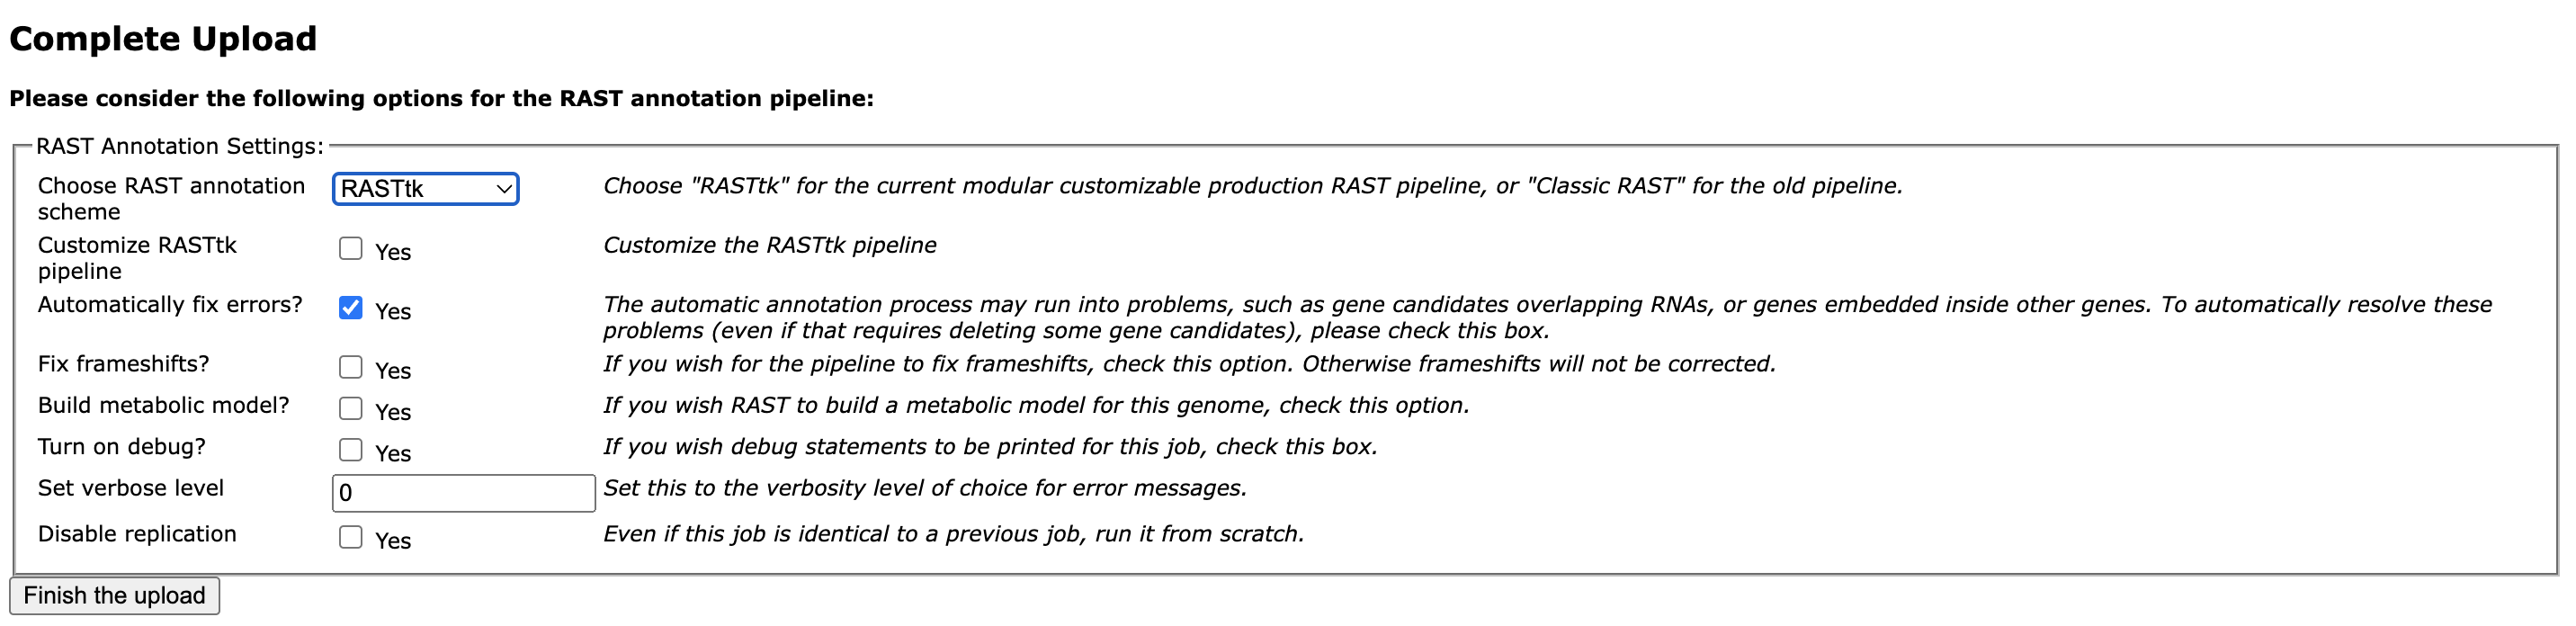